In [50]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [38]:
df_train = pd.read_csv('../sentiment_analysis/train.tsv', sep='\t')
df_test = pd.read_csv('../sentiment_analysis/test.tsv', sep='\t')

In [39]:
df_train

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
...,...,...,...,...
156055,156056,8544,Hearst 's,2
156056,156057,8544,forced avuncular chortles,1
156057,156058,8544,avuncular chortles,3
156058,156059,8544,avuncular,2


In [40]:
df_test

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine
...,...,...,...
66287,222348,11855,"A long-winded , predictable scenario ."
66288,222349,11855,"A long-winded , predictable scenario"
66289,222350,11855,"A long-winded ,"
66290,222351,11855,A long-winded


## sentiment label

The sentiment labels are:

0 - negative
1 - somewhat negative
2 - neutral
3 - somewhat positive
4 - positive

In [41]:
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
import nltk
# Stopword function
def stopword(string):
    from nltk.corpus import stopwords
    res = [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(res)

# Initialize lemmatizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
wl = WordNetLemmatizer()

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
# Tokenize Summaries
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    res = [wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(res)

In [42]:
# Text pre-processing
def get_pre_preprocessing(df1,col):
    import pandas as pd
    import re
    from nltk.tokenize import RegexpTokenizer
    import numpy as np
    df = df1.copy()
# Convert Summary data to type(str)
    df[col] = df[col].apply(lambda x: str(x))
# Remove html tags and leading 'b's
    df[col] = df[col].apply(lambda row: re.compile(r'<.*?>').sub(r' ',row))
# Remove special characters, replace with space
    df[col] = df[col].apply(lambda row: re.compile(r'\W').sub(r' ',row))
# Remove single characters
    df[col] = df[col].apply(lambda row: re.compile(r'\s+[a-zA-Z]\s+').sub(r' ',row))
# Remove stil characters from start
    df[col] = df[col].apply(lambda row: re.compile(r'\^[a-zA-Z]\s+').sub(r' ',row))
# Clean up multi-space gaps
    df[col] = df[col].apply(lambda row: re.compile(r'\s+').sub(r' ',row))
# Converting to lower case
    df[col] = df[col].apply(lambda row: row.lower())
# Apply stopwords func to Summaries
    df[col] = df[col].apply(lambda text: stopword(text))
# Apply lemmatizer func to Summaries
    df[col] = df[col].apply(lambda text: lemmatizer(text))
# Initialize tokenizer and tokenize summary data
    tokenizer = RegexpTokenizer(r'\w+')
#apply tokinizer to text data
    df[col] = df[col].apply(tokenizer.tokenize)
# Create token length count column
    df['token_count'] = [len(x) for x in df[col]]
# Calculate standard deviation of token counts
    print(pd.DataFrame.std(df.token_count, ddof=2))
# Checking standard deviation using np
    arr = pd.Series.to_numpy(df.token_count)
    print(np.std(arr, ddof=2))
#add the tokenize column to the original column 
    df1['token'] = df[col]
    df1['token_count'] = df['token_count']
    return df1

In [43]:
df_train = get_pre_preprocessing(df_train,'Phrase')

3.5825579340894045
3.5825579340894045


In [45]:
#removing columns with no tokens
df_train['length'] = df_train.apply(lambda row: len(row['token']),axis=1)
df_train = df_train[df_train['length']!=0]
#keep only length, x and y columns
df_train = df_train[['token','Sentiment','length']]

In [46]:
df_train

,token,Sentiment,length
0,"[series, escapades, demonstrating, adage, good...",1,15
1,"[series, escapades, demonstrating, adage, good...",2,6
2,[series],2,1
4,[series],2,1
5,"[escapade, demonstrate, adage, good, goose]",2,5
...,...,...,...
156055,[hearst],2,1
156056,"[force, avuncular, chortle]",1,3
156057,"[avuncular, chortle]",3,2
156058,[avuncular],2,1


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


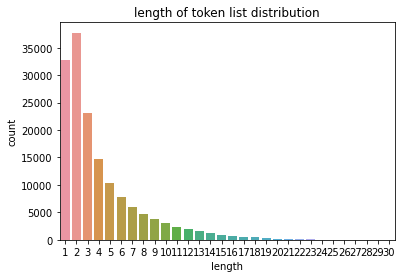

In [51]:
#token distribution
sns.countplot(df_train['length'])
plt.title('length of token list distribution');

In [52]:
import sklearn.feature_extraction.text as text
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
from sklearn.metrics import fowlkes_mallows_score
from sklearn.metrics import accuracy_score


tf = text.TfidfVectorizer(stop_words='english')
lsvc = LinearSVC()

X_train_tf = tf.fit_transform(df_train['token'])
X_test_tf = tf.transform(df_test['Phrase'])

model = lsvc.fit(X_train_tf,df_train['Sentiment'])
y_pred2 = model.predict(X_test_tf)

AttributeError: 'list' object has no attribute 'lower'